# Titanic: Machine Learning from Disaster

### Executive Summary
In this project, the dataset we use is the famous Titanic dataset on Kaggle (https://www.kaggle.com/c/titanic). We will run 10 common Machine Learning Algorithms to predict the survival rate of the passengers. The objective of this project is to increase the accuracy of the prediction by processing the dataset using feature engineering and to discover the the most well-proformed algorithm among the 10 machine learning methods. Our first step is to use exploratory data analysis (EDA) to look at the dataset closely to make sure we understand the dataset fully and then we will do the further cleaning and feature engineering to help the dataset fits our machine learning models well. In our last step, we found that the decision tree classifier returns the greatest value.

### Variable Description
<ul>
<li><b>PassengerId</b>: Passenger ID
<li><b>Survived</b>: Survival (0 = No, 1 = Yes)
<li><b>Pclass</b>: Ticket class (1 = First class, 2 = Second class, 3 = Third class)
<li><b>Name</b>: Name of the passenger
<li><b>Sex</b>: Sex of the passenger
<li><b>Age</b>: Age in years
<li><b>SibSp</b>: Number of siblings or spouses on board
<li><b>Parch</b>: Number of parents or children on board
<li><b>Ticket</b>: Ticket number
<li><b>Fare</b>: Passenger fare
<li><b>Cabin</b>: Cabin number
<li><b>Embarked</b>: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

### Exploratory Data Analysis (EDA)
We believe understanding the dataset first before we make any changes of the dataset is a very important step. In this section, we found that the passengers in the 1st class have the higher survival rate as well as the female passengers, so we can reasonably assume that the evacuation started from the 1st class and the priority was given to the female passengers. Before EDA, we were assuming that every class might embark from a certain entrance, but after EDA, we found that the passengers could embark the ship from the entrance they prefered.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score ,auc, roc_curve
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, neural_network
import xgboost as xgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df[['Pclass', 'Survived']].groupby(by='Pclass').mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


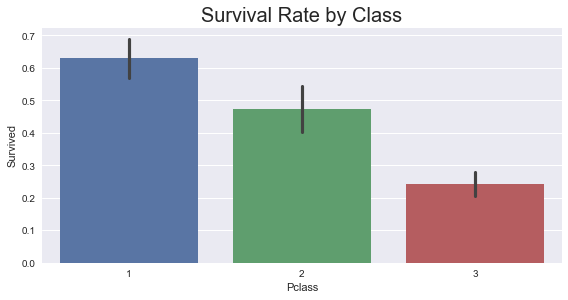

In [6]:
sns.factorplot(y='Survived', x='Pclass', data=df, kind='bar', aspect=2)
plt.title('Survival Rate by Class', fontsize=20)

In [7]:
df[['Sex', 'Survived']].groupby(by='Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


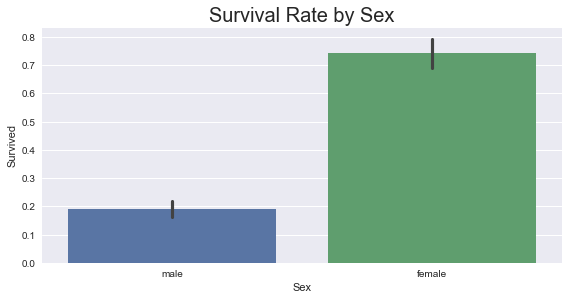

In [8]:
sns.factorplot(y='Survived', x='Sex', data=df, kind='bar', aspect=2)
plt.title('Survival Rate by Sex', fontsize=20)

In [9]:
df[['Embarked', 'Survived']].groupby(by='Embarked').mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


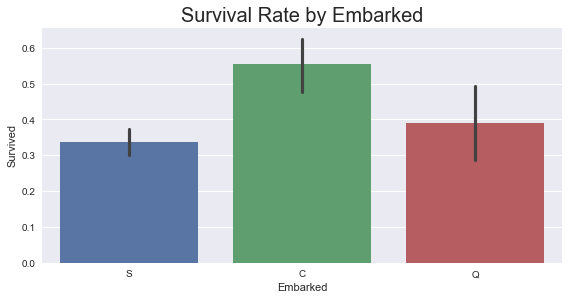

In [10]:
sns.factorplot(y='Survived', x='Embarked', data=df, kind='bar', aspect=2)
plt.title('Survival Rate by Embarked', fontsize=20)

### Cleaning
In this section, we will drop the variables that we won't include in our model, change the Sex and Embarked variables from categorical to numerical, and fill the NAs in the Age variable with its midean.
<ul>
<li><b>Drop the PassengerId variable</b>: Since the ID doesn't have specific meaning, it won't help us to improve the accuracy of our model.
<li><b>Drop the Name variable</b>: Although the name variable contains the title of each person, we believe the information has already been covered by the Pclass and the Fare variables.
<li><b>Drop the Ticket variable</b>: Similar to the name variable, we believe the information has already been covered by the the Pclass and the Fare variables.
<li><b>Drop the cabin variable</b>: This variable only has 204 non-null objects, which are greater than the number of 1st class, so we assume that some of the information in this variable is missing.

In [11]:
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [12]:
df['Age'] = df.Age.fillna(df.Age.median())

In [13]:
df['Sex'] = pd.get_dummies(df['Sex'], drop_first=True).astype('int')

In [14]:
Embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}
df['Embarked'] = df['Embarked'].fillna(df.Embarked.mode()[0]).map(Embarked_mapping)

### Feature Engineering
In this section, we will transform some variables to help improve the accuracy of our model. By performing feature engineering, we transform the dat into features that better represent the underlying problem to the predictive models.
<ul>
<li><b>The Age variable</b>: We separate this variable into 5 bins. 
<li><b>The Fare variable</b>: We separate this variable into 4 bins.
<li><b>The SibSp and Parch variables</b>: We combine the numbers of these two into one variable named Family.

In [15]:
df['AgeBin'] = pd.cut(df.Age, 5)
df[['Survived', 'AgeBin']].groupby(by='AgeBin').mean()

,Survived
AgeBin,
"(0.34, 16.336]",0.550000
"(16.336, 32.252]",0.344168
"(32.252, 48.168]",0.404255
"(48.168, 64.084]",0.434783
"(64.084, 80.0]",0.090909


In [16]:
df['Age'] = pd.cut(df.Age, 5, labels=False)
df = df.drop('AgeBin', axis=1)

In [17]:
df['FareBin'] = pd.cut(df.Fare, 4)
df[['Survived', 'FareBin']].groupby(by='FareBin').mean()

,Survived
FareBin,
"(-0.512, 128.082]",0.368113
"(128.082, 256.165]",0.724138
"(256.165, 384.247]",0.666667
"(384.247, 512.329]",1.000000


In [18]:
df['Fare'] = pd.cut(df.Fare, 4, labels=False)
df = df.drop('FareBin', axis=1)

In [19]:
df['Family'] = df.SibSp + df.Parch
df = df.drop(['SibSp', 'Parch'], axis=1)

### Machine Learning Algorithms
We will apply 10 machine learning algorithms for classification in this section. The area under the ROC curve will be used to evaluate which algorithm predicts the classes best. The greater the AUC value is, the better the model predicts. Our result shows that the Decision tree classifier returns the greatest value.
<ul>
<li><b>Algorithms</b>: Logistic regression, k-nearest neighbors, SVM, Naive Bayes, Decision tree, Random forest, Linear discriminant analysis, Quadratic discriminant analysis, Neural network (MLP), Xgboost

In [20]:
X = df.drop('Survived', axis=1)
Y = df.Survived
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

In [21]:
MLA = [
    linear_model.LogisticRegressionCV(),
    neighbors.KNeighborsClassifier(3),
    svm.SVC(gamma=2, C=1),
    naive_bayes.GaussianNB(),
    tree.DecisionTreeClassifier(max_depth=3),
    ensemble.RandomForestClassifier(max_depth=3, n_estimators=10, max_features=1),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    discriminant_analysis.LinearDiscriminantAnalysis(),
    neural_network.MLPClassifier(alpha=1)
]

In [22]:
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)

row_index = 0
for alg in MLA:
    predicted = alg.fit(X_train, Y_train).predict(X_test)
    fp, tp, th = roc_curve(Y_test, predicted)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'Precision'] = precision_score(Y_test, predicted)
    MLA_compare.loc[row_index, 'AUC'] = auc(fp, tp)
    
    row_index+=1
MLA_compare.sort_values(by = ['AUC'], ascending = False, inplace = True)
MLA_compare

,MLA Name,Precision,AUC
4,DecisionTreeClassifier,0.793103,0.773526
8,MLPClassifier,0.718310,0.772543
0,LogisticRegressionCV,0.688312,0.768480
7,LinearDiscriminantAnalysis,0.693333,0.765924
2,SVC,0.738462,0.764875
3,GaussianNB,0.710145,0.758257
6,QuadraticDiscriminantAnalysis,0.701493,0.743971
1,KNeighborsClassifier,0.626667,0.707274
5,RandomForestClassifier,0.703704,0.698034


In [23]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dtest = xgb.DMatrix(X_test, label=Y_test)

In [24]:
clf = xgb.XGBClassifier(n_estimators=500, objective='binary:logistic', eval_metric='auc', eta=0.1, max_depth=6, subsample=1, colsample_bytree=0.3, silent=1)
clf.fit(X_train, Y_train, early_stopping_rounds=20, eval_metric="auc", eval_set=[(X_test, Y_test)])

[0]	validation_0-auc:0.524443
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.629554
[2]	validation_0-auc:0.69384
[3]	validation_0-auc:0.704194
[4]	validation_0-auc:0.704587
[5]	validation_0-auc:0.708519
[6]	validation_0-auc:0.704653
[7]	validation_0-auc:0.705701
[8]	validation_0-auc:0.704915
[9]	validation_0-auc:0.70557
[10]	validation_0-auc:0.704784
[11]	validation_0-auc:0.704522
[12]	validation_0-auc:0.705046
[13]	validation_0-auc:0.704784
[14]	validation_0-auc:0.704128
[15]	validation_0-auc:0.705832
[16]	validation_0-auc:0.704522
[17]	validation_0-auc:0.70059
[18]	validation_0-auc:0.701376
[19]	validation_0-auc:0.701507
[20]	validation_0-auc:0.705046
[21]	validation_0-auc:0.705308
[22]	validation_0-auc:0.705439
[23]	validation_0-auc:0.702031
[24]	validation_0-auc:0.701769
[25]	validation_0-auc:0.701376
Stopping. Best iteration:
[5]	validation_0-auc:0.708519



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, eta=0.1, eval_metric='auc', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=1)